In [1]:
import geopandas as gpd
import os
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
import matplotlib.pyplot as plt

os.chdir("/home/silas/projects/msc_thesis")

figure_dir = "docs/reports/thesis/figures/"

In [3]:
# import flats dataset with duration to nearest recycling point
flats_duration = gpd.read_file(r'./data/derived_data/flats_subset_with_rcp.gpkg')

#import rcp dataset
rcps = gpd.read_file(r'./data/raw_data/geodata_stadt_Zuerich/recycling_sammelstellen/data/stzh.poi_sammelstelle_view.shp')

# convert crs to 3857
flats_duration = flats_duration.to_crs(epsg=4326)
rcps = rcps.to_crs(epsg=4326)


In [ ]:
# count the number of flats per recycling point and add to the rcp dataset
# flats_count = flats_duration.groupby('rcp').size().reset_index(name='count')

# merge the count with the rcp dataset
# rcps = rcps.merge(flats_count, left_on='OBJECTID', right_on='rcp', how='left')



KeyError: 'OBJECTID'

In [ ]:

# load the data


# visualize the results 
# Create a base map
m = folium.Map(location=[47.3769, 8.5417], zoom_start=12)

# Create a colormap for the duration
colormap = folium.LinearColormap(colors=['green', 'yellow', 'red'], vmin=flats_duration['duration'].min(), vmax=flats_duration['duration'].max(), caption='Duration to Closest RCP (minutes)')

# Add flats to the map
for idx, row in flats_duration.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=6,
        color=colormap(row['duration']),
        fill=True,
        fill_color=colormap(row['duration']),
        fill_opacity=0.7,
        popup=f"Flat ID: {row['egid']}<br>Duration: {row['duration']:.2f} min"
    ).add_to(m)

# Add recycling points to the map
for idx, row in rcps.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        icon=folium.Icon(color='green', icon='recycle', prefix='fa', ),
        popup=f"RCP ID: {idx}<br>Address: {row['adresse']}", radius=3
    ).add_to(m)

# Add the colormap to the map
colormap.add_to(m)

m.save(figure_dir + 'points_rcp_map.html')
# Display the map
m

# Interactive heatmap with folium

In [29]:
# create a heat map with folium

# Create a base map
m = folium.Map(location=[47.3769, 8.5417], zoom_start=12)

# Create a colormap for the duration
colormap = folium.LinearColormap(
    colors=['green', 'yellow', 'red'],
    vmin=flats_duration['duration'].min(),
    vmax=flats_duration['duration'].max()
)
colormap.caption = 'Duration to Closest RCP (minutes)'

# Prepare data for heatmap
heat_data = [[row.geometry.y, row.geometry.x, row['duration']] for idx, row in flats_duration.iterrows()]

# Add recycling points to the map
for idx, row in rcps.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        fill=True,
        icon=folium.Icon(color='green', icon='recycle', prefix='fa'),
        fill_opacity=0.7,
        color='red',
        popup=f"RCP ID: {idx}<br>Address: {row['adresse']}"
    ).add_to(m)

# Create and add heatmap to the map
HeatMap(heat_data, radius=15, blur=7, max_zoom=1).add_to(m)

# Add a scale bar using MeasureControl
folium.plugins.MeasureControl(position='bottomleft').add_to(m)

# Add a north arrow that moves with the map
# Define north arrow HTML
north_arrow_html = '''
<div style="position: fixed; bottom: 90px; left: 90px; width: 100px; height: 100px; z-index:9999;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/e/ef/North_arrow.svg" style="width:100%; height:100%;">
</div>
'''

m.get_root().html.add_child(folium.Element(north_arrow_html))

# Update legend to remove flat entry
legend_html = '''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 150px; height: 60px; 
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color:white;
            ">
    &nbsp;<b>Legend</b><br>
    &nbsp;<i class="fa fa-recycle fa-2x" style="color:green"></i>&nbsp; Recycling Points<br>
</div>
'''

# Add a legend for the colormap
colormap.add_to(m)
m.get_root().html.add_child(folium.Element(legend_html))

# save the map
m.save(figure_dir + 'heat_map.html')
m


# Static heatmap

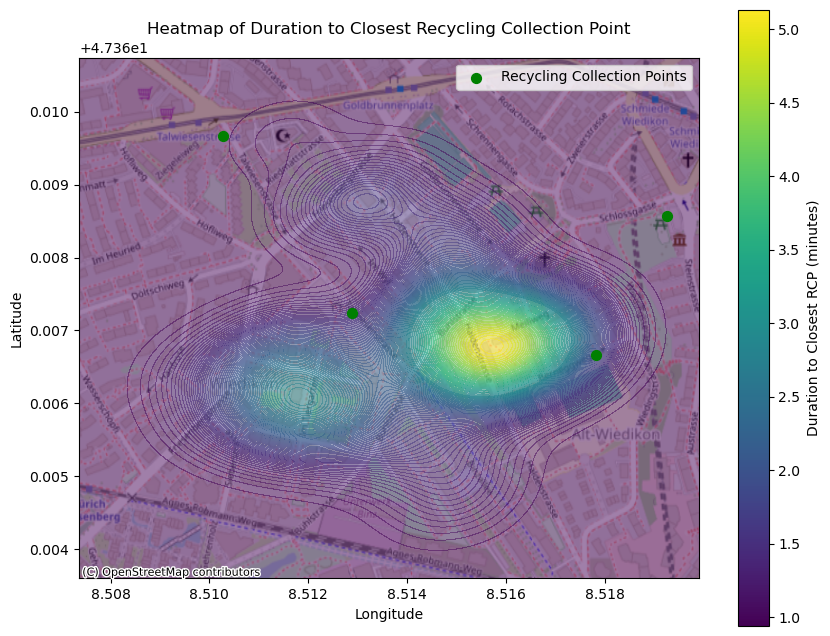

In [85]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx

# Create a DataFrame for the heatmap
heat_df = pd.DataFrame({
    'Longitude': flats_duration.geometry.x,
    'Latitude': flats_duration.geometry.y,
    'Duration': flats_duration['duration']
})

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the heatmap without iso lines
kde = sns.kdeplot(
    data=heat_df,
    x='Longitude',
    y='Latitude',
    weights='Duration',
    cmap='viridis', 
    fill=True,
    thresh=0,
    levels=100,
    alpha=0.5,
    ax=ax
)

# Add the basemap
ctx.add_basemap(
    ax,
    crs=flats_duration.crs.to_string(),
    source=ctx.providers.OpenStreetMap.Mapnik
)

# Plot the RCPs
rcps.plot(
    ax=ax,
    color='green',
    markersize=50,
    label='Recycling Collection Points'
)

# Add a colorbar
norm = plt.Normalize(vmin=heat_df['Duration'].min(), vmax=heat_df['Duration'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', label='Duration to Closest RCP (minutes)')

# Set titles and labels
ax.set_title('Heatmap of Duration to Closest Recycling Collection Point')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()

# Save and show the figure
plt.savefig(figure_dir + 'static_heatmap_with_basemap.png', dpi=300)
plt.show()